<a href="https://colab.research.google.com/github/jessebuyungo/yield_prediction/blob/main/Maize_phenology_rwimi_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import ee
import geemap
import pandas as pd
import numpy as np
import datetime

In [2]:
# 1. Authenticate and Initialize Earth Engine
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize(project='ee-jessebuyungo113')

print("Google Earth Engine initialized.")


Google Earth Engine initialized.


In [3]:
# get area of intreset shapefile
asset_id = 'projects/ee-jessebuyungo113/assets/rwimi'
aoi= ee.FeatureCollection(asset_id )
print("Succes")

Succes


In [4]:
# Define your date range
start_date = '2020-01-01'
end_date = '2024-12-31'

In [5]:
# sentinel 2
s2_collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
.filterDate(start_date, end_date) \
.filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 50)) \
.filterBounds(aoi) \



# Landsat 8


In [6]:
# prompt: create a cloud mask for the s2_collection

def maskS2clouds(image):
    """Masks clouds in a Sentinel-2 image using the QA60 band."""
    qa = image.select('QA60')

    # Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11

    # Both flags should be set to zero, indicating clear conditions.
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(
        qa.bitwiseAnd(cirrusBitMask).eq(0))

    # Return the masked and scaled data, without the QA60 band.
    return image.updateMask(mask).divide(10000)

# Apply the cloud mask to the collection
s2_collection_masked = s2_collection.map(maskS2clouds)

print("Sentinel-2 collection masked for clouds.")

Sentinel-2 collection masked for clouds.


In [7]:
# Define the server-side function to process each image
def process_single_image_server_side(image):
    """
    This function processes a single image on the Earth Engine server.
    It takes an ee.Image as input and returns an ee.Feature with calculated properties.
    """
    # Keep variable names from your original snippet where applicable for server-side objects
    cloud = image.get('CLOUDY_PIXEL_PERCENTAGE')
    system_time_start = image.get('system:time_start')
    image =  maskS2clouds(image)

    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')

    # Perform reductions on the server
    median_ndvi_dict = ndvi.reduceRegion(reducer=ee.Reducer.median(), geometry=aoi, scale=10, bestEffort=True)
    mean_ndvi_dict = ndvi.reduceRegion(reducer=ee.Reducer.mean(), geometry=aoi, scale=10, bestEffort=True)

    # Return a Feature with the desired properties (still server-side)
    return ee.Feature(None, {
        'date_ms': system_time_start, # Keep as milliseconds for server-side
        'cloud_cover': cloud,
        'mean_ndvi': mean_ndvi_dict.get('NDVI'),
        'median_ndvi': median_ndvi_dict.get('NDVI')
    })

# Apply the server-side function to the entire image_list collection
print("Starting server-side processing...")
results_collection = s2_collection.map(process_single_image_server_side)

# Fetch all results from the server in one go
# This is the only place .getInfo() is called for the entire collection's data
print("Fetching results from GEE servers... This might take a moment.")
all_server_results = results_collection.getInfo()
print("Results fetched!")

# Initialize your results_data list
results_data = []

# Process the results client-side after they have been fetched
# Loop through the features contained within 'all_server_results'
for features_dict in all_server_results['features']:
    properties = features_dict['properties']

    # Your original variable names for client-side use
    cloud = properties['cloud_cover']
    system_time_start = properties['date_ms']
    kkk=1
    # Add a check to see if system_time_start is not None before processing
    if system_time_start is not None:
        # Convert timestamp to a human-readable date client-side
        date_object = datetime.datetime.fromtimestamp(system_time_start / 1000) # Convert ms to s
        image_date = date_object.strftime('%Y-%m-%d') # Format as YYYY-MM-DD

        # Your original variable names for client-side use
        mean_ndvi = properties['mean_ndvi']
        median_ndvi = properties['median_ndvi']

        print(f"Date: {image_date}, Cloud Cover: {cloud}%, mean ndvi: {mean_ndvi}, median ndvi: {median_ndvi}")

        results_data.append({
            'date': image_date,
            'cloud_cover': cloud,
            'mean_ndvi': mean_ndvi,
            'median_ndvi': median_ndvi
        })
    else:
        print("Skipping feature with missing system:time_start property.")


# The 'results_data' list now contains all your processed data
print("\nFinal collected data:")
print(results_data)

Starting server-side processing...
Fetching results from GEE servers... This might take a moment.
Results fetched!
Date: 2020-01-23, Cloud Cover: 11.991728%, mean ndvi: 0.5786213110550433, median ndvi: 0.5869451879814921
Date: 2020-02-02, Cloud Cover: 42.383652%, mean ndvi: 0.504609207997262, median ndvi: 0.5799857731886224
Date: 2020-02-07, Cloud Cover: 6.080016%, mean ndvi: 0.5348725998793865, median ndvi: 0.6230802845245685
Date: 2020-02-12, Cloud Cover: 8.163921%, mean ndvi: 0.42683908325873204, median ndvi: 0.4512964825638318
Date: 2020-02-17, Cloud Cover: 31.45232%, mean ndvi: 0.14520419001674484, median ndvi: 0.14213378334984517
Date: 2020-03-03, Cloud Cover: 7.785439%, mean ndvi: 0.19377349771977137, median ndvi: 0.18558467753907285
Date: 2020-03-23, Cloud Cover: 48.731219%, mean ndvi: 0.08221769470746415, median ndvi: 0.07947694663999705
Date: 2020-04-02, Cloud Cover: 34.417811%, mean ndvi: 0.5972369982967233, median ndvi: 0.6034559647796306
Date: 2020-04-07, Cloud Cover: 11.0

In [8]:

df = pd.DataFrame(results_data)

# Convert 'date' column to datetime objects for proper time-series handling
df['date'] = pd.to_datetime(df['date'])

# Sort by date (optional, but good practice for time series)
df = df.sort_values(by='date').reset_index(drop=True)
df

,date,cloud_cover,mean_ndvi,median_ndvi
0,2020-01-23,11.991728,0.578621,0.586945
1,2020-02-02,42.383652,0.504609,0.579986
2,2020-02-07,6.080016,0.534873,0.623080
3,2020-02-12,8.163921,0.426839,0.451296
4,2020-02-17,31.452320,0.145204,0.142134
...,...,...,...,...
137,2024-09-18,31.148395,0.329408,0.314348
138,2024-10-13,41.483992,0.568787,0.605340
139,2024-12-07,20.285214,0.728472,0.728469
140,2024-12-17,37.952721,0.577492,0.564589


In [9]:
# prompt: extract a dataframe pf median ndvi and dates

# Select only the 'date' and 'median_ndvi' columns
df_median_ndvi = df[['date', 'median_ndvi']].copy()

print("\nDataFrame with Date and Median NDVI:")
df_median_ndvi


DataFrame with Date and Median NDVI:


,date,median_ndvi
0,2020-01-23,0.586945
1,2020-02-02,0.579986
2,2020-02-07,0.623080
3,2020-02-12,0.451296
4,2020-02-17,0.142134
...,...,...
137,2024-09-18,0.314348
138,2024-10-13,0.605340
139,2024-12-07,0.728469
140,2024-12-17,0.564589


In [10]:
# prompt: resample the median ndvi to fortnight dates

# Set the date column as the index
df_median_ndvi.set_index('date', inplace=True)

# Resample the median_ndvi to a fortnight (2-week) frequency, taking the median within each period
# '2W' represents a 2-week frequency
# .median() calculates the median of the 'median_ndvi' values within each 2-week period
df_fortnightly_median_ndvi = df_median_ndvi.resample('2W').median()

print("\nFortnightly Median NDVI (resampled):")
df_fortnightly_median_ndvi


Fortnightly Median NDVI (resampled):


,median_ndvi
date,
2020-01-26,0.586945
2020-02-09,0.601533
2020-02-23,0.296715
2020-03-08,0.185585
2020-03-22,NaN
...,...
2024-11-10,NaN
2024-11-24,NaN
2024-12-08,0.728469



Fortnightly Median NDVI (cleaned - NaNs removed):
            median_ndvi
date                   
2020-01-26     0.586945
2020-02-09     0.601533
2020-02-23     0.296715
2020-03-08     0.185585
2020-04-05     0.341466
...                 ...
2024-09-29     0.314348
2024-10-13     0.605340
2024-12-08     0.728469
2024-12-22     0.564589
2025-01-05     0.607363

[96 rows x 1 columns]


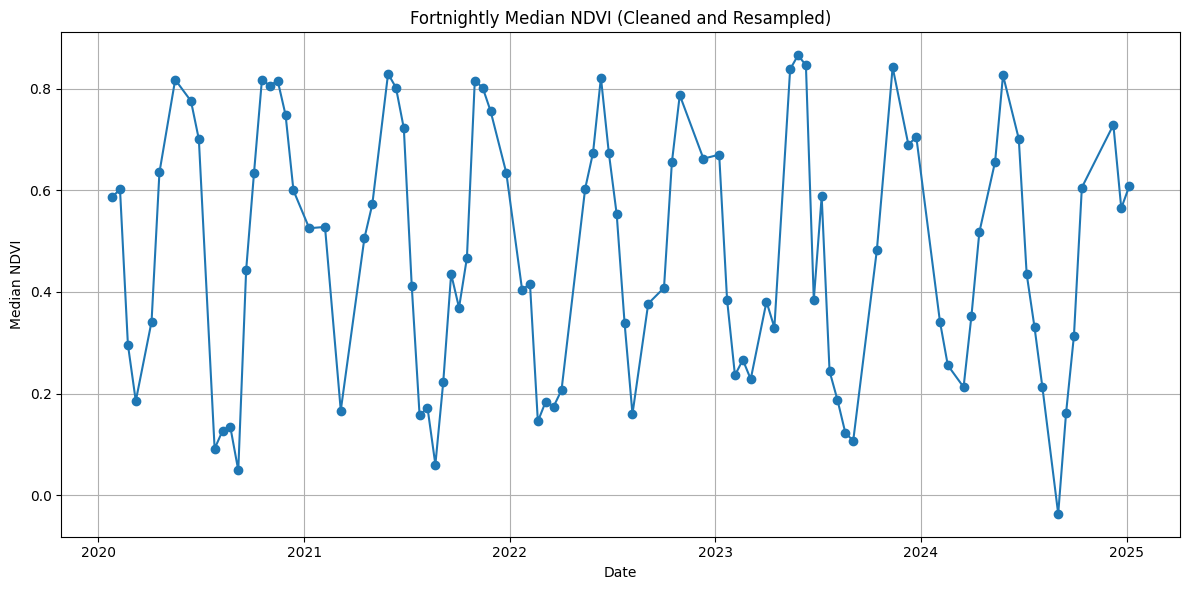

In [11]:
# prompt: remove the no data values and plot the sampled data

import matplotlib.pyplot as plt

# Remove rows where 'median_ndvi' is NaN (No Data)
df_fortnightly_median_ndvi_cleaned = df_fortnightly_median_ndvi.dropna(subset=['median_ndvi'])

print("\nFortnightly Median NDVI (cleaned - NaNs removed):")
print(df_fortnightly_median_ndvi_cleaned)

# Plot the cleaned, sampled data
plt.figure(figsize=(12, 6))
plt.plot(df_fortnightly_median_ndvi_cleaned.index, df_fortnightly_median_ndvi_cleaned['median_ndvi'], marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Median NDVI')
plt.title('Fortnightly Median NDVI (Cleaned and Resampled)')
plt.grid(True)
plt.tight_layout()
plt.show()

/tmp/ipython-input-12-834854955.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fortnightly_median_ndvi_cleaned['rolling_mean_4'] = df_fortnightly_median_ndvi_cleaned['median_ndvi'].rolling(window=4).mean()



Fortnightly Median NDVI with Rolling Mean (Window 4):
            median_ndvi  rolling_mean_4
date                                   
2020-01-26     0.586945             NaN
2020-02-09     0.601533             NaN
2020-02-23     0.296715             NaN
2020-03-08     0.185585        0.417695
2020-04-05     0.341466        0.356325
...                 ...             ...
2024-09-29     0.314348        0.163173
2024-10-13     0.605340        0.261426
2024-12-08     0.728469        0.452573
2024-12-22     0.564589        0.553186
2025-01-05     0.607363        0.626440

[96 rows x 2 columns]


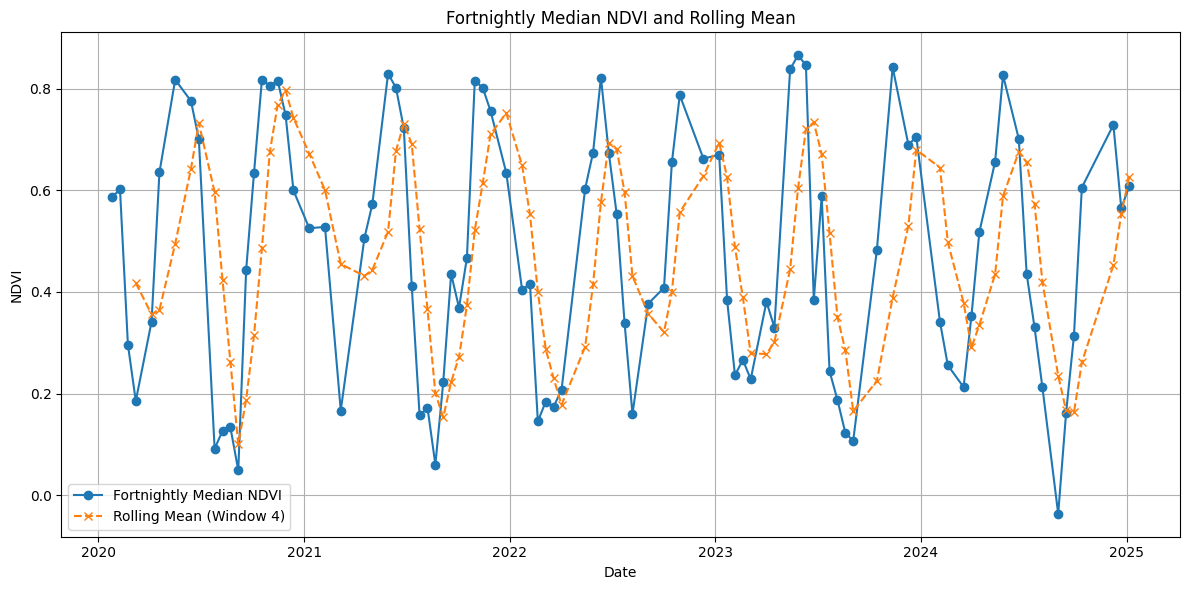

In [12]:
# prompt: Calculate a rolling mean with a window of 4 steps on the fortning ndvi

# Calculate the rolling mean with a window of 4
df_fortnightly_median_ndvi_cleaned['rolling_mean_4'] = df_fortnightly_median_ndvi_cleaned['median_ndvi'].rolling(window=4).mean()

print("\nFortnightly Median NDVI with Rolling Mean (Window 4):")
print(df_fortnightly_median_ndvi_cleaned)

# Plot the original and rolling mean data
plt.figure(figsize=(12, 6))
plt.plot(df_fortnightly_median_ndvi_cleaned.index, df_fortnightly_median_ndvi_cleaned['median_ndvi'], marker='o', linestyle='-', label='Fortnightly Median NDVI')
plt.plot(df_fortnightly_median_ndvi_cleaned.index, df_fortnightly_median_ndvi_cleaned['rolling_mean_4'], marker='x', linestyle='--', label='Rolling Mean (Window 4)')
plt.xlabel('Date')
plt.ylabel('NDVI')
plt.title('Fortnightly Median NDVI and Rolling Mean')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [13]:
df_fortnightly_median_ndvi_cleaned

,median_ndvi,rolling_mean_4
date,,
2020-01-26,0.586945,NaN
2020-02-09,0.601533,NaN
2020-02-23,0.296715,NaN
2020-03-08,0.185585,0.417695
2020-04-05,0.341466,0.356325
...,...,...
2024-09-29,0.314348,0.163173
2024-10-13,0.605340,0.261426
2024-12-08,0.728469,0.452573



DataFrame with Rolling Mean (Window 4) - NaNs Dropped:
            median_ndvi  rolling_mean_4
date                                   
2020-03-08     0.185585        0.417695
2020-04-05     0.341466        0.356325
2020-04-19     0.634995        0.364690
2020-05-17     0.817393        0.494860
2020-06-14     0.775408        0.642316
...                 ...             ...
2024-09-29     0.314348        0.163173
2024-10-13     0.605340        0.261426
2024-12-08     0.728469        0.452573
2024-12-22     0.564589        0.553186
2025-01-05     0.607363        0.626440

[93 rows x 2 columns]


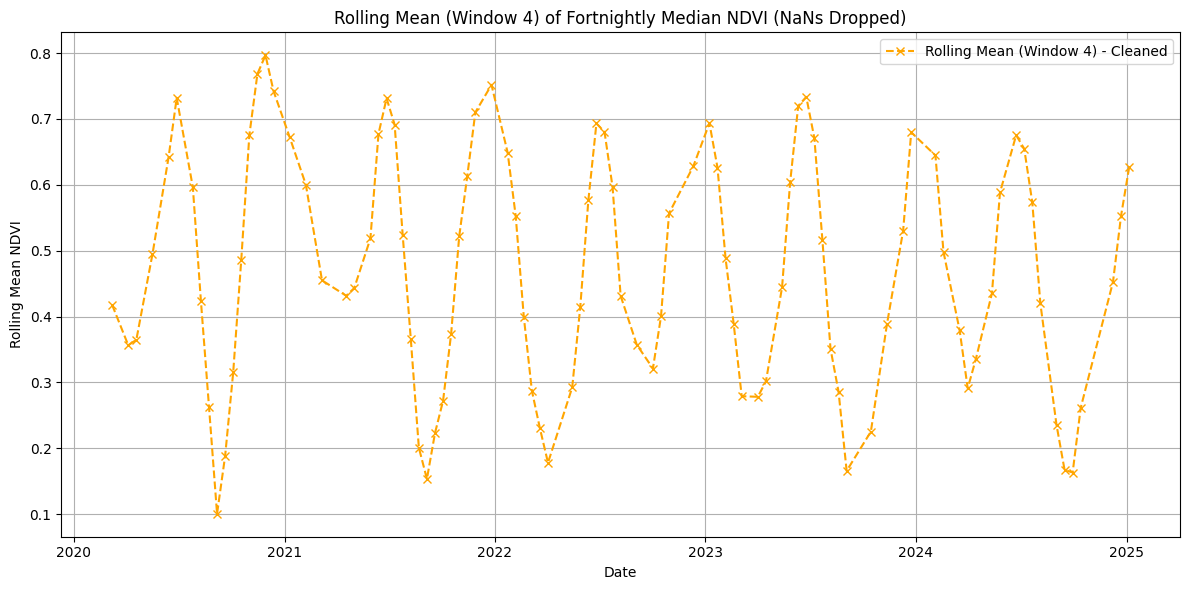

,median_ndvi,rolling_mean_4
date,,
2020-03-08,0.185585,0.417695
2020-04-05,0.341466,0.356325
2020-04-19,0.634995,0.364690
2020-05-17,0.817393,0.494860
2020-06-14,0.775408,0.642316
...,...,...
2024-09-29,0.314348,0.163173
2024-10-13,0.605340,0.261426
2024-12-08,0.728469,0.452573


In [14]:
# prompt: create a datframe for rolling mean_4 and drop all the nan values

# Drop rows where 'rolling_mean_4' is NaN
df_rolling_mean_cleaned = df_fortnightly_median_ndvi_cleaned.dropna(subset=['rolling_mean_4']).copy()

print("\nDataFrame with Rolling Mean (Window 4) - NaNs Dropped:")
print(df_rolling_mean_cleaned)

# Plot only the rolling_mean_4 data after dropping NaNs
plt.figure(figsize=(12, 6))
plt.plot(df_rolling_mean_cleaned.index, df_rolling_mean_cleaned['rolling_mean_4'], marker='x', linestyle='--', color='orange', label='Rolling Mean (Window 4) - Cleaned')
plt.xlabel('Date')
plt.ylabel('Rolling Mean NDVI')
plt.title('Rolling Mean (Window 4) of Fortnightly Median NDVI (NaNs Dropped)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

df_rolling_mean_cleaned



Daily Interpolated Rolling Mean NDVI:
            rolling_mean_4  rolling_mean_4_interpolated
2020-03-08        0.417695                     0.417695
2020-03-09             NaN                     0.415503
2020-03-10             NaN                     0.413311
2020-03-11             NaN                     0.411119
2020-03-12             NaN                     0.408927
...                    ...                          ...
2025-01-01             NaN                     0.605510
2025-01-02             NaN                     0.610743
2025-01-03             NaN                     0.615975
2025-01-04             NaN                     0.621208
2025-01-05        0.626440                     0.626440

[1765 rows x 2 columns]


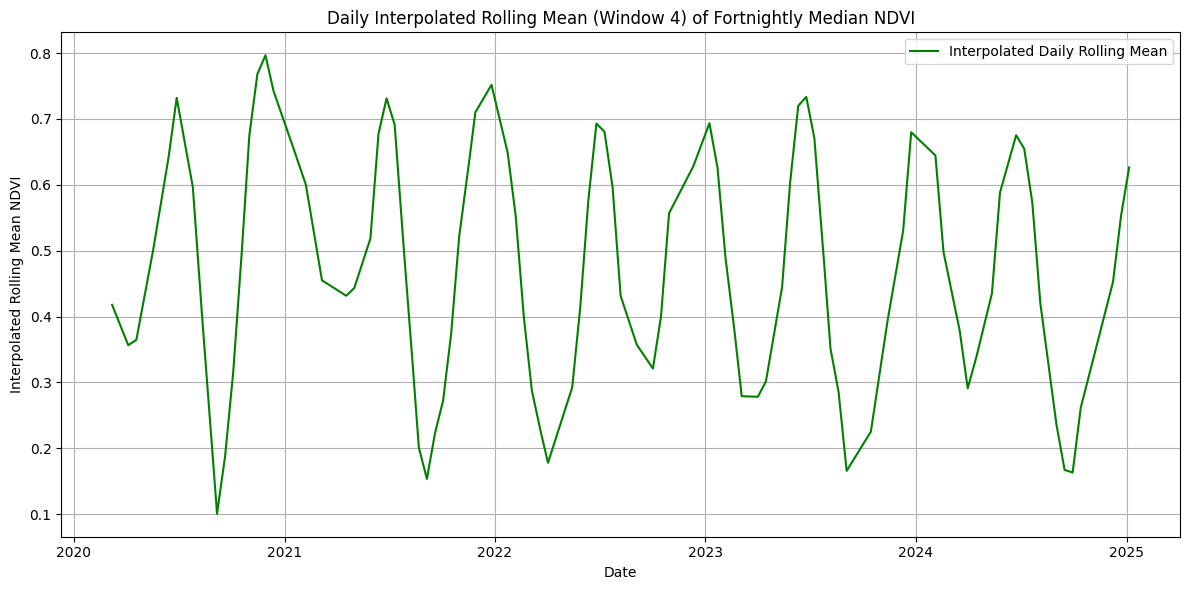

In [17]:
# prompt: interpolate the dates to daily values

# Create a new DataFrame with a daily frequency covering the entire range
# of the original rolling mean data
df_daily = pd.DataFrame(index=pd.date_range(start=df_rolling_mean_cleaned.index.min(),
                                            end=df_rolling_mean_cleaned.index.max(),
                                            freq='D'))

# Join the original rolling mean data with the new daily index
df_daily = df_daily.join(df_rolling_mean_cleaned['rolling_mean_4'])

# Interpolate the missing daily values using a linear method
df_daily['rolling_mean_4_interpolated'] = df_daily['rolling_mean_4'].interpolate(method='linear')

print("\nDaily Interpolated Rolling Mean NDVI:")
print(df_daily)

# Plot the interpolated daily data
plt.figure(figsize=(12, 6))
plt.plot(df_daily.index, df_daily['rolling_mean_4_interpolated'], linestyle='-', color='green', label='Interpolated Daily Rolling Mean')
plt.xlabel('Date')
plt.ylabel('Interpolated Rolling Mean NDVI')
plt.title('Daily Interpolated Rolling Mean (Window 4) of Fortnightly Median NDVI')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Detected Approximate Start Dates of Seasons based on Median of Positive Slope:
2020-04-21
2020-09-21
2021-05-03
2021-09-09
2022-04-14
2022-12-12
2023-04-17
2023-11-13
2024-04-01
2024-10-14


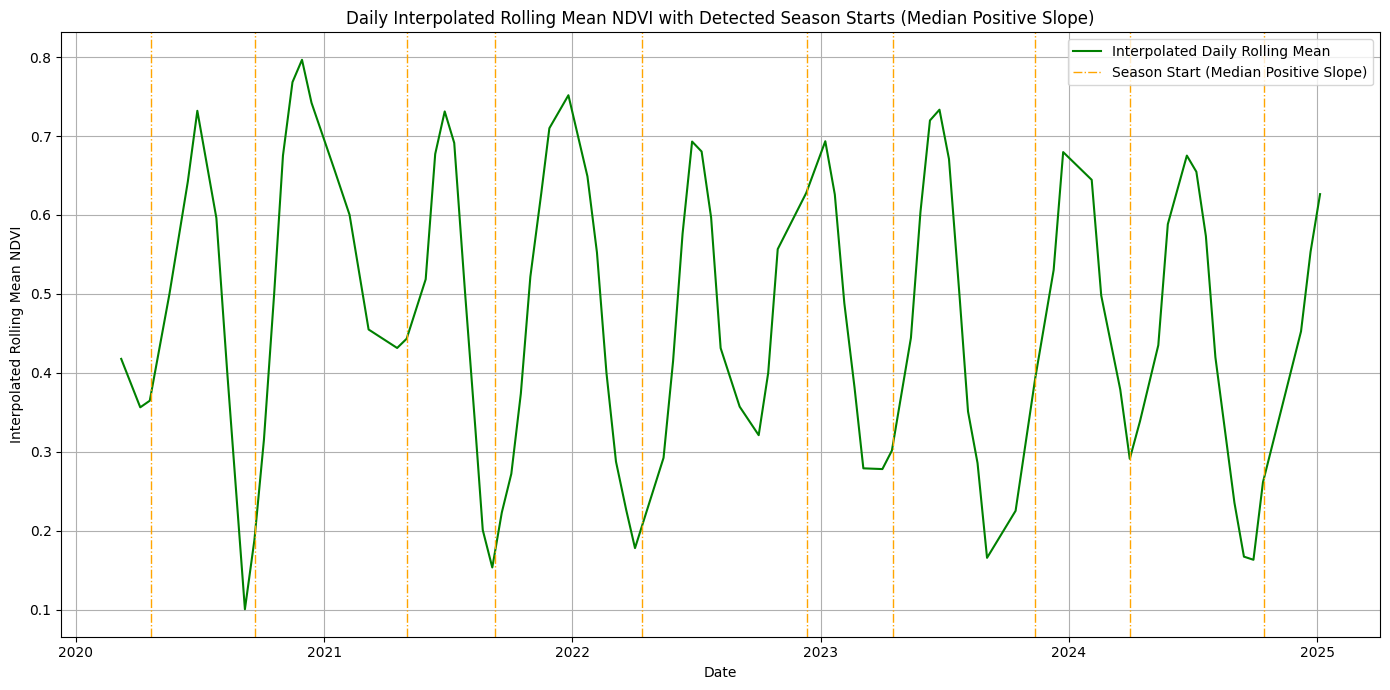

In [18]:
# prompt: determine start of season using the median of the postive slope on the greening side of the curve

# Calculate the slope (rate of change) of the interpolated NDVI
df_daily['slope'] = df_daily['rolling_mean_4_interpolated'].diff()


def find_season_starts_median_positive_slope(df_daily):
    """
    Finds the approximate start of each season by identifying greening periods
    (consecutive positive slopes) and determining the date within each period
    corresponding to the median of the positive slopes.

    Args:
        df_daily (pd.DataFrame): DataFrame with a 'slope' column
                                 representing the daily NDVI change.

    Returns:
        list: A list of pandas Timestamps representing the approximate
              start dates of each season.
    """
    season_starts = []
    current_greening_period_dates = []

    # Iterate through the daily interpolated data to identify continuous greening periods
    for i in range(len(df_daily)):
        current_date = df_daily.index[i]
        current_slope = df_daily['slope'].iloc[i]

        # Check if the current slope is positive (indicating greening) and not NaN
        if pd.notna(current_slope) and current_slope > 0:
            current_greening_period_dates.append(current_date)
        else:
            # If the slope is not positive, or is NaN, the greening period has ended (or hasn't started yet)
            if current_greening_period_dates:
                # Process the completed greening period
                greening_period_df = df_daily.loc[current_greening_period_dates].copy()

                # Ensure there are positive slopes in this period before calculating median
                positive_slopes_in_period = greening_period_df[greening_period_df['slope'] > 0]['slope']

                if not positive_slopes_in_period.empty:
                    # Calculate the median of the *positive* slopes within this specific greening period
                    median_positive_slope_value = positive_slopes_in_period.median()

                    # Find the date within this greening period where the positive slope is closest to the median positive slope
                    # We only consider dates where the slope is positive for finding the index
                    if not pd.isna(median_positive_slope_value):
                         # Filter the DataFrame slice to only include positive slopes for finding the closest date
                        positive_greening_period_df = greening_period_df[greening_period_df['slope'] > 0]
                        if not positive_greening_period_df.empty:
                            slope_differences = np.abs(positive_greening_period_df['slope'] - median_positive_slope_value)
                            # Use idxmin() to get the date (index) corresponding to the minimum difference
                            approx_start_date = slope_differences.idxmin()
                            season_starts.append(approx_start_date)

                # Reset the list for the next potential greening period
                current_greening_period_dates = []

    # Handle the last greening period if the data ends during one
    if current_greening_period_dates:
        greening_period_df = df_daily.loc[current_greening_period_dates].copy()
        positive_slopes_in_period = greening_period_df[greening_period_df['slope'] > 0]['slope']
        if not positive_slopes_in_period.empty:
             median_positive_slope_value = positive_slopes_in_period.median()
             if not pd.isna(median_positive_slope_value):
                positive_greening_period_df = greening_period_df[greening_period_df['slope'] > 0]
                if not positive_greening_period_df.empty:
                    slope_differences = np.abs(positive_greening_period_df['slope'] - median_positive_slope_value)
                    approx_start_date = slope_differences.idxmin()
                    season_starts.append(approx_start_date)


    # Sort the detected season starts chronologically
    season_starts.sort()

    # Filter out dates that are too close to each other to avoid detecting multiple starts in one season
    # A minimum separation of, say, 30 days could be reasonable depending on the expected season length.
    if season_starts:
        filtered_season_starts = [season_starts[0]]
        min_days_apart = 30 # Define a minimum gap between season starts
        for i in range(1, len(season_starts)):
            if (season_starts[i] - filtered_season_starts[-1]).days > min_days_apart:
                filtered_season_starts.append(season_starts[i])
        return filtered_season_starts
    else:
        return []


# Find the season start dates using the median of positive slope approach
season_start_dates_median_positive_slope = find_season_starts_median_positive_slope(df_daily)

print("\nDetected Approximate Start Dates of Seasons based on Median of Positive Slope:")
for date in season_start_dates_median_positive_slope:
    print(date.date())

# Plot the interpolated data and mark the detected season start dates using the median positive slope method
plt.figure(figsize=(14, 7))
plt.plot(df_daily.index, df_daily['rolling_mean_4_interpolated'], linestyle='-', color='green', label='Interpolated Daily Rolling Mean')

# Plot vertical lines at the detected start of seasons
for date in season_start_dates_median_positive_slope:
    plt.axvline(date, color='orange', linestyle='-.', linewidth=1, label='Season Start (Median Positive Slope)' if date == season_start_dates_median_positive_slope[0] else "")

plt.xlabel('Date')
plt.ylabel('Interpolated Rolling Mean NDVI')
plt.title('Daily Interpolated Rolling Mean NDVI with Detected Season Starts (Median Positive Slope)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Detected Approximate End Dates of Seasons based on Median of Negative Slope:
2020-03-09
2020-08-10
2020-12-28
2021-07-29
2022-03-07
2022-08-08
2023-01-10
2023-08-26
2024-02-19
2024-07-08


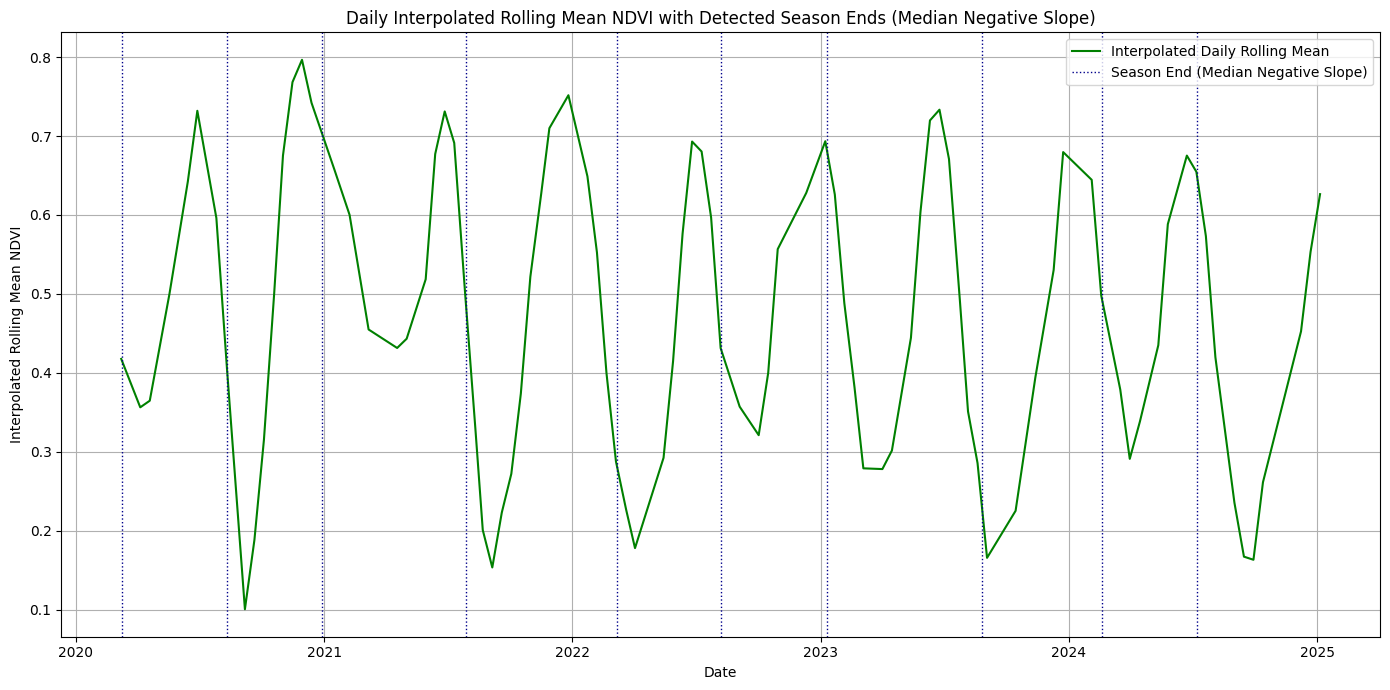

In [19]:
# prompt: determine end of season using the median of the negative slopes on the  senescing side of the curve

def find_season_ends_median_negative_slope(df_daily):
    """
    Finds the approximate end of each season by identifying senescing periods
    (consecutive negative slopes) and determining the date within each period
    corresponding to the median of the negative slopes.

    Args:
        df_daily (pd.DataFrame): DataFrame with a 'slope' column
                                 representing the daily NDVI change.

    Returns:
        list: A list of pandas Timestamps representing the approximate
              end dates of each season.
    """
    season_ends = []
    current_senescing_period_dates = []

    # Iterate through the daily interpolated data to identify continuous senescing periods
    for i in range(len(df_daily)):
        current_date = df_daily.index[i]
        current_slope = df_daily['slope'].iloc[i]

        # Check if the current slope is negative (indicating senescing) and not NaN
        if pd.notna(current_slope) and current_slope < 0:
            current_senescing_period_dates.append(current_date)
        else:
            # If the slope is not negative, or is NaN, the senescing period has ended (or hasn't started yet)
            if current_senescing_period_dates:
                # Process the completed senescing period
                senescing_period_df = df_daily.loc[current_senescing_period_dates].copy()

                # Ensure there are negative slopes in this period before calculating median
                negative_slopes_in_period = senescing_period_df[senescing_period_df['slope'] < 0]['slope']

                if not negative_slopes_in_period.empty:
                    # Calculate the median of the *negative* slopes within this specific senescing period
                    median_negative_slope_value = negative_slopes_in_period.median()

                    # Find the date within this senescing period where the negative slope is closest to the median negative slope
                    # We only consider dates where the slope is negative for finding the closest date
                    if not pd.isna(median_negative_slope_value):
                         # Filter the DataFrame slice to only include negative slopes for finding the closest date
                        negative_senescing_period_df = senescing_period_df[senescing_period_df['slope'] < 0]
                        if not negative_senescing_period_df.empty:
                            # Calculate the absolute difference for finding the closest value (closest to median_negative_slope_value which is negative)
                            # This correctly identifies the point on the negative slope that is closest to the median value.
                            slope_differences = np.abs(negative_senescing_period_df['slope'] - median_negative_slope_value)
                            # Use idxmin() to get the date (index) corresponding to the minimum difference
                            approx_end_date = slope_differences.idxmin()
                            season_ends.append(approx_end_date)

                # Reset the list for the next potential senescing period
                current_senescing_period_dates = []

    # Handle the last senescing period if the data ends during one
    if current_senescing_period_dates:
        senescing_period_df = df_daily.loc[current_senescing_period_dates].copy()
        negative_slopes_in_period = senescing_period_df[senescing_period_df['slope'] < 0]['slope']
        if not negative_slopes_in_period.empty:
             median_negative_slope_value = negative_slopes_in_period.median()
             if not pd.isna(median_negative_slope_value):
                negative_senescing_period_df = senescing_period_df[senescing_period_df['slope'] < 0]
                if not negative_senescing_period_df.empty:
                    slope_differences = np.abs(negative_senescing_period_df['slope'] - median_negative_slope_value)
                    approx_end_date = slope_differences.idxmin()
                    season_ends.append(approx_end_date)


    # Sort the detected season ends chronologically
    season_ends.sort()

    # Filter out dates that are too close to each other to avoid detecting multiple ends in one season
    # A minimum separation of, say, 30 days could be reasonable depending on the expected season length.
    if season_ends:
        filtered_season_ends = [season_ends[0]]
        min_days_apart = 30 # Define a minimum gap between season ends
        for i in range(1, len(season_ends)):
            if (season_ends[i] - filtered_season_ends[-1]).days > min_days_apart:
                filtered_season_ends.append(season_ends[i])
        return filtered_season_ends
    else:
        return []

# Find the season end dates using the median of negative slope approach
season_end_dates_median_negative_slope = find_season_ends_median_negative_slope(df_daily)

print("\nDetected Approximate End Dates of Seasons based on Median of Negative Slope:")
for date in season_end_dates_median_negative_slope:
    print(date.date())

# Plot the interpolated data and mark the detected season end dates using the median negative slope method
plt.figure(figsize=(14, 7))
plt.plot(df_daily.index, df_daily['rolling_mean_4_interpolated'], linestyle='-', color='green', label='Interpolated Daily Rolling Mean')

# Plot vertical lines at the detected end of seasons
for date in season_end_dates_median_negative_slope:
    plt.axvline(date, color='darkblue', linestyle=':', linewidth=1, label='Season End (Median Negative Slope)' if date == season_end_dates_median_negative_slope[0] else "")

plt.xlabel('Date')
plt.ylabel('Interpolated Rolling Mean NDVI')
plt.title('Daily Interpolated Rolling Mean NDVI with Detected Season Ends (Median Negative Slope)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
# prompt: put the startt of season and end of season in a sequency from the first date to the last one

# Combine season start and end dates into a single list
all_season_dates = season_start_dates_median_positive_slope + season_end_dates_median_negative_slope

# Sort the combined list chronologically
all_season_dates.sort()

print("\nSequence of Detected Season Start and End Dates:")
for date in all_season_dates:
    print(date.date())

# Create a list of labels indicating whether the date is a start or an end
labels = []
for date in all_season_dates:
    if date in season_start_dates_median_positive_slope:
        labels.append('Start')
    elif date in season_end_dates_median_negative_slope:
        labels.append('End')
    else:
        # This case should ideally not happen if the lists are correct
        labels.append('Unknown')

# Create a DataFrame to display the sequence with labels
df_season_sequence = pd.DataFrame({
    'Date': all_season_dates,
    'Event': labels
})

print("\nDataFrame showing the Sequence of Season Starts and Ends:")
df_season_sequence



Sequence of Detected Season Start and End Dates:
2020-03-09
2020-04-21
2020-08-10
2020-09-21
2020-12-28
2021-05-03
2021-07-29
2021-09-09
2022-03-07
2022-04-14
2022-08-08
2022-12-12
2023-01-10
2023-04-17
2023-08-26
2023-11-13
2024-02-19
2024-04-01
2024-07-08
2024-10-14

DataFrame showing the Sequence of Season Starts and Ends:


,Date,Event
0,2020-03-09,End
1,2020-04-21,Start
2,2020-08-10,End
3,2020-09-21,Start
4,2020-12-28,End
5,2021-05-03,Start
6,2021-07-29,End
7,2021-09-09,Start
8,2022-03-07,End
9,2022-04-14,Start


In [21]:
# prompt: compute the length of each season

# Assuming 'df_season_sequence' is already created and sorted by 'Date'

season_durations = []

# Iterate through the sequence of events to find consecutive start and end dates
for i in range(len(df_season_sequence) - 1):
    current_event = df_season_sequence.iloc[i]
    next_event = df_season_sequence.iloc[i+1]

    # If the current event is a 'Start' and the next event is an 'End', calculate the duration
    if current_event['Event'] == 'Start' and next_event['Event'] == 'End':
        duration = next_event['Date'] - current_event['Date']
        season_durations.append({
            'Season_Start_Date': current_event['Date'].date(),
            'Season_End_Date': next_event['Date'].date(),
            'Duration_Days': duration.days
        })

# Create a DataFrame from the calculated durations
df_season_durations = pd.DataFrame(season_durations)

print("\nCalculated Season Durations:")
print(df_season_durations)

# Optional: Print average duration
if not df_season_durations.empty:
    average_duration = df_season_durations['Duration_Days'].mean()
    print(f"\nAverage Season Duration: {average_duration:.2f} days")
else:
    print("\nNo complete seasons (Start followed by End) found.")



Calculated Season Durations:
  Season_Start_Date Season_End_Date  Duration_Days
0        2020-04-21      2020-08-10            111
1        2020-09-21      2020-12-28             98
2        2021-05-03      2021-07-29             87
3        2021-09-09      2022-03-07            179
4        2022-04-14      2022-08-08            116
5        2022-12-12      2023-01-10             29
6        2023-04-17      2023-08-26            131
7        2023-11-13      2024-02-19             98
8        2024-04-01      2024-07-08             98

Average Season Duration: 105.22 days


In [22]:
# prompt: # prompt: for each seson above, can you compute the following
# #SOS = Date of start of season
# #         POS = Date of peak of season
# #         EOS = Date of end of season
# #         vSOS = Value at start of season
# #         vPOS = Value at peak of season
# #         vEOS = Value at end of season
# #         Trough = Minimum value of season
# #         LOS = Length of season (Days)
# #         AOS = Amplitude of season (in value units)
# #         ROG = Rate of greening
# #         ROS = Rate of senescence
# #export the data as a dataframe

# Ensure 'df_daily' has the 'rolling_mean_4_interpolated' column and is indexed by date
if 'rolling_mean_4_interpolated' not in df_daily.columns:
    print("Error: 'rolling_mean_4_interpolated' column not found in df_daily.")
    # Re-run the interpolation if necessary or handle the error appropriately
    # For this example, we'll assume it exists from the preceding code.
    pass

def find_peak_of_season(df_daily, start_date, end_date):
    """
    Finds the date of the peak of the season (maximum NDVI) within a given period.

    Args:
        df_daily (pd.DataFrame): DataFrame with a date index and
                                 'rolling_mean_4_interpolated' column.
        start_date (pd.Timestamp): The start date of the season period.
        end_date (pd.Timestamp): The end date of the season period.

    Returns:
        pd.Timestamp or None: The date of the peak NDVI within the period,
                              or None if the period is invalid or no data.
    """
    if start_date >= end_date:
        return None # Invalid period

    # Select the data within the season period (inclusive of start and end dates)
    season_data = df_daily.loc[start_date:end_date].copy()

    if season_data.empty:
        return None # No data in this period

    # Find the date with the maximum interpolated NDVI value
    # Use idxmax() to get the index (date) of the maximum value
    pos_date = season_data['rolling_mean_4_interpolated'].idxmax()

    return pos_date

def calculate_season_metrics(df_daily, season_periods):
    """
    Calculates various phenological metrics for each defined season period.

    Args:
        df_daily (pd.DataFrame): DataFrame with a date index and
                                 'rolling_mean_4_interpolated' column.
        season_periods (list of tuples): A list where each tuple is
                                        (start_date, end_date) for a season.

    Returns:
        pd.DataFrame: A DataFrame containing the calculated metrics for each season.
    """
    season_metrics_list = []

    for sos_date, eos_date in season_periods:
        # Ensure start and end dates are valid Timestamps and in the correct order
        if not isinstance(sos_date, pd.Timestamp) or not isinstance(eos_date, pd.Timestamp) or sos_date >= eos_date:
            print(f"Skipping invalid season period: Start={sos_date}, End={eos_date}")
            continue

        # Define the period for the current season
        season_period_data = df_daily.loc[sos_date:eos_date].copy()

        if season_period_data.empty:
            print(f"Skipping season period with no data: Start={sos_date}, End={eos_date}")
            continue

        # SOS = Date of start of season
        SOS = sos_date

        # EOS = Date of end of season
        EOS = eos_date

        # LOS = Length of season (Days)
        LOS = (EOS - SOS).days

        # vSOS = Value at start of season
        vSOS = season_period_data.loc[SOS, 'rolling_mean_4_interpolated']

        # vEOS = Value at end of season
        vEOS = season_period_data.loc[EOS, 'rolling_mean_4_interpolated']

        # POS = Date of peak of season
        POS = find_peak_of_season(df_daily, SOS, EOS)

        # vPOS = Value at peak of season
        vPOS = season_period_data.loc[POS, 'rolling_mean_4_interpolated'] if POS else np.nan

        # Trough = Minimum value of season
        # Find the minimum value within the season period
        Trough = season_period_data['rolling_mean_4_interpolated'].min()

        # AOS = Amplitude of season (in value units)
        # Amplitude is typically the difference between the peak and the minimum
        AOS = vPOS - Trough if POS and not pd.isna(vPOS) and not pd.isna(Trough) else np.nan

        # ROG = Rate of greening
        # Rate of greening is the slope from SOS to POS
        ROG = (vPOS - vSOS) / (POS - SOS).days if POS and SOS != POS and not pd.isna(vPOS) and not pd.isna(vSOS) else np.nan

        # ROS = Rate of senescence
        # Rate of senescence is the slope from POS to EOS
        ROS = (vEOS - vPOS) / (EOS - POS).days if POS and EOS != POS and not pd.isna(vEOS) and not pd.isna(vPOS) else np.nan


        season_metrics_list.append({
            'SOS': SOS.date(),
            'POS': POS.date() if POS else None,
            'EOS': EOS.date(),
            'vSOS': vSOS,
            'vPOS': vPOS,
            'vEOS': vEOS,
            'Trough': Trough,
            'LOS': LOS,
            'AOS': AOS,
            'ROG': ROG,
            'ROS': ROS
        })

    # Create a DataFrame from the calculated metrics
    df_season_metrics = pd.DataFrame(season_metrics_list)

    return df_season_metrics

# Prepare the season periods based on the df_season_durations DataFrame
# Each period is a tuple of (Start Date, End Date)
season_periods = [(row['Season_Start_Date'], row['Season_End_Date'])
                  for index, row in df_season_durations.iterrows()]

# Convert date objects in season_periods back to pandas Timestamps for slicing df_daily
season_periods_ts = [(pd.Timestamp(start), pd.Timestamp(end)) for start, end in season_periods]

# Calculate the metrics for each season
df_season_metrics = calculate_season_metrics(df_daily, season_periods_ts)

print("\nCalculated Season Phenological Metrics:")
df_season_metrics

# Export the data as a dataframe
# The df_season_metrics DataFrame already holds the computed metrics.
# You can optionally save it to a file like CSV.
# df_season_metrics.to_csv('season_phenology_metrics.csv', index=False)
# print("\nSeason phenology metrics exported to 'season_phenology_metrics.csv'")



Calculated Season Phenological Metrics:


,SOS,POS,EOS,vSOS,vPOS,vEOS,Trough,LOS,AOS,ROG,ROS
0,2020-04-21,2020-06-28,2020-08-10,0.373988,0.732004,0.412140,0.373988,111,0.358016,0.005265,-0.007439
1,2020-09-21,2020-11-29,2020-12-28,0.197440,0.796617,0.704617,0.197440,98,0.599178,0.008684,-0.003172
2,2021-05-03,2021-06-27,2021-07-29,0.445925,0.731202,0.478396,0.445925,87,0.285277,0.005187,-0.007900
3,2021-09-09,2021-12-26,2022-03-07,0.173316,0.751731,0.283491,0.173316,179,0.578415,0.005356,-0.006595
4,2022-04-14,2022-06-26,2022-08-08,0.207927,0.693041,0.428698,0.207927,116,0.485114,0.006645,-0.006148
5,2022-12-12,2023-01-08,2023-01-10,0.630354,0.693453,0.683809,0.630354,29,0.063099,0.002337,-0.004822
6,2023-04-17,2023-06-25,2023-08-26,0.306636,0.733421,0.234245,0.234245,131,0.499175,0.006185,-0.008051
7,2023-11-13,2023-12-24,2024-02-19,0.393771,0.679692,0.493757,0.393771,98,0.285921,0.006974,-0.003262
8,2024-04-01,2024-06-23,2024-07-08,0.294164,0.675262,0.648927,0.294164,98,0.381098,0.004592,-0.001756
